##### Ratio of recovered uncertainties of the semi-major axis between the scenario with and without diversity in observations for nine asteroids and their dependence on asteroid distances from Earth. The uncertainty values are derived with Find_Orb and shown in Table 4.

##### Step 1: Here we import all the packages used throughout the notebook:

In [6]:
# For numerical arrays and dataframes.
import numpy as np
import pandas as pd

# For handling plotting and axis formatting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# For custom subplot layouts
from matplotlib.gridspec import GridSpec

# Tools for fitting functions to data
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit

# For file handling and regular expressions
import re
import os
from pathlib import Path

# Access to trigonometric functions and constants
import math

# Used to manually create custom legend entries
from matplotlib.lines import Line2D

# 
from datetime import datetime

#
import shutil

##### Step 2: Reading and Extracting the raw data of the nine asteroids from the NASA JPL Horizon System

In [7]:
# txt_files_folder  = where the Horizons .txt files are stored
# csv_output_folder = where the converted .csv files will be saved
txt_files_folder  = '/hpc/home/mf342/Maryann et al. 2025/Figure 9/'
csv_output_folder = '/hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs'

# Prevents errors when attempting to save files.
# os.makedirs() creates the folder if it is missing.
if not os.path.exists(csv_output_folder):
    os.makedirs(csv_output_folder)
    print(f"Created output folder: {csv_output_folder}")

# In the list, the following are column headers in the DataFrame. The blanks denoted by '' correspond to columns that are not required in the analysis. 
# A pandas.DataFrame is created using the specified column names.
columns = ['Date__(UT)__HR:MN', '', '', ' R.A._(ICRF)', 'DEC__(ICRF)', 'delta', 'deldot', '', ' RA_3sigma', 'DEC_3sigma']

# Lists every item in the folder. Each file will be examined to see whether it should be processed
for file_name in os.listdir(txt_files_folder):

    # The file to process must have an extension of .txt
    if file_name.endswith('.txt'):
        file_path = os.path.join(txt_files_folder, file_name)

        # We only want to extract the code between “SOE” (Start of Ephemeris) and “EOE” (End of Ephemeris), since they contain the ephemeris data. 
        start_marker = "$$SOE"
        end_marker = "$$EOE"
        
        # This list will store the ephemeris rows after extraction.
        data_lines = []
        
        try:
            # open: opens the file in read mode ('r'). The with statement ensures that the file is closed properly after it is read.
            with open(file_path, 'r') as file:
                
                # is_data is a Boolean flag. It indicates if an ephemeris row of data is within the appropriate data section row.
                is_data = False
                
                # Iterates through every line 
                for line in file:

                    # When a row of lines contains SOE, the start marker, the is_data is set to True. Beyond this line, data will be captured.
                    if start_marker in line:
                        is_data = True
                        
                    # When a row of lines contains EOE, the end marker, the is_data is set to False. Beyond this line, data will not be captured.
                    elif end_marker in line:
                        is_data = False
                        
                    # In the case if neither marker is found, and is_data is true, this means that data capturing is still on-going, and hasn't reached EOE. 
                    elif is_data:
                        # .strip() removes whitespace and appends lines to data_lines.
                        data_lines.append(line.strip())
            
            # Each line of ephemeris data that is captured is split at the commas to form string values that are in the form of rows and columns (lists of lists) for the .csv. 
            data = [line.split(",") for line in data_lines]

            # max_columns searches for the longest row and its length.
            max_columns = max(len(row) for row in data)
            
            # Shorter rows are padded with empty strings at locations that do not have data, to represent the same length as the longest row. 
            # This is to make sure that the DataFrame is being created without misaligned columns.
            data = [row + [''] * (max_columns - len(row)) for row in data]

            # Convert the rows and columns data into a pandas.DataFrame, assigning the predefined column names from columns. 
            df = pd.DataFrame(data, columns=columns[:max_columns])

            # os.path.basename(file_path) extracts the filename
            # os.path.splitext(...)[0] removes the file extension (.txt)
            base_name = os.path.splitext(file_name)[0]

            # A new .csv is appended to the newly created file
            csv_file_path = os.path.join(csv_output_folder, f'{base_name}.csv')

            # The DataFrame is exported to a .csv file. Passing index=False prevents the DataFrame’s index from being written as an extra column.
            df.to_csv(csv_file_path, index=False)
            print(f"CSV file saved: {csv_file_path}")

        # If a file is missing or unreadable → show a friendly message.
        # If something unexpected goes wrong → print the specific error.
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/2024 ON (6 days but 4th day with NO diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/2024 SJ (6 days but 4th day with diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/2014 GL1 (6 days but 4th day with diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/2014 GL1 (6 days but 4th day with NO diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/2024 ON (6 days but 4th day with diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/2024 SH7 (6 days but 4th day with NO diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/2024 SH7 (6 days but 4th day with diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/2024 RN15 (6 days but 4th day with NO diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al.

##### Step 3: Convert the data to .obs file for inputting into Find_Orb

In [8]:
# Create subfolder for .obs files
formatted_folder = os.path.join(csv_output_folder, "formatted_obs")
# make the folder only if it doesn't exist
os.makedirs(formatted_folder, exist_ok=True)

# Function to convert one measurement row into MPC .obs format
def format_mpc(date_str, ra, dec, observatory='807'):
    
    # Convert the Horizons timestamp string into a datetime object
    dt = datetime.strptime(date_str.strip(), "%Y-%b-%d %H:%M:%S.%f")

    # Convert time-of-day into fractional day for MPC's YYYY MM DD.ddddd format
    day_fraction = dt.day + (dt.hour + dt.minute / 60 + dt.second / 3600 + dt.microsecond / 1e6 / 3600) / 24
    
    # Format date for MPC: must begin with "C" and contain year, month, and fractional day
    date_fmt = f"C{dt.year:04d} {dt.month:02d} {day_fraction:08.5f}"
    
    # Break RA string into hours, minutes, seconds
    ra_h, ra_m, ra_s = ra.strip().split()

    # Format RA into MPC-required fixed-width columns
    ra_fmt = f"{int(ra_h):02d} {int(ra_m):02d} {float(ra_s):05.2f}"

    # Determine whether DEC is positive or negative
    sign = '+' if '+' in dec else '-'

    # Remove sign and split into degrees, arcminutes, arcseconds
    d, m, s = dec.replace('+','').replace('-','').split()

    # Format DEC into MPC fixed-width format with sign
    dec_fmt = f"{sign}{int(d):02d} {int(m):02d} {float(s):04.1f}"

    # Construct the final MPC observation line with proper spacing + observatory code
    return f"             {date_fmt} {ra_fmt} {dec_fmt}                      {observatory}"

# Convert every CSV inside csv_output_folder into a .obs file
for file_name in os.listdir(csv_output_folder):

    # Only process CSV files
    if file_name.endswith('.csv'):

        try:

            # Full path to CSV
            csv_path = os.path.join(csv_output_folder, file_name)

            # Read CSV into DataFrame
            df = pd.read_csv(csv_path)

            # Remove extra spaces from column names
            df.columns = df.columns.str.strip()

            # Convert each row into an MPC-formatted line using the formatter defined above
            lines = [
                format_mpc(row['Date__(UT)__HR:MN'], row['R.A._(ICRF)'], row['DEC__(ICRF)'])
                for _, row in df.iterrows()     # Loop over each observation
            ]

            # Create output file name with .obs extension
            obs_path = os.path.join(formatted_folder, f"{os.path.splitext(file_name)[0]}.obs")
            
            # Write all MPC lines into the .obs output file
            with open(obs_path, 'w') as f:
                f.write("\n".join(lines) + "\n")
            print(f" MPC file saved: {obs_path}")

        # Catch any errors in processing
        except Exception as e:
            print(f" Error in {file_name}: {e}")



 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/formatted_obs/2024 RN15 (6 days but 4th day with NO diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/formatted_obs/2024 RJ16 (6 days but 4th day with diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/formatted_obs/2022 QV1 (6 days but 4th day with diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/formatted_obs/2014 GL1 (6 days but 4th day with NO diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/formatted_obs/2024 RN15 (6 days but 4th day with diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/formatted_obs/2024 SJ (6 days but 4th day with diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9/mpc_obs/formatted_obs/2024 RO2 (6 days but 4th day with diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9

##### Step 4: Print the .obs files for input into Find_Orb for each of the asteroids 

In [9]:
# Print all MPC-formatted data from all .obs files

for file_name in sorted(os.listdir(formatted_folder)):
    if file_name.endswith('.obs'):
        print(f"\n📄 {file_name}")
        
        with open(os.path.join(formatted_folder, file_name), 'r') as f:
            print(f.read())


📄 2014 GL1 (6 days but 4th day with NO diversity).obs
             C2024 08 31.00000 16 40 26.40 -29 14 30.1                      807
             C2024 09 01.00000 16 40 36.45 -29 10 03.5                      807
             C2024 09 02.00000 16 40 49.50 -29 05 43.9                      807
             C2024 09 03.00000 16 41 05.48 -29 01 31.1                      807
             C2024 09 04.00000 16 41 24.34 -28 57 25.0                      807
             C2024 09 05.00000 16 41 46.03 -28 53 25.6                      807


📄 2014 GL1 (6 days but 4th day with diversity).obs
             C2024 08 31.00000 16 40 26.40 -29 14 30.1                      807
             C2024 09 01.00000 16 40 36.45 -29 10 03.5                      807
             C2024 09 02.00000 16 40 49.50 -29 05 43.9                      807
             C2024 09 03.95833 16 41 23.65 -28 57 35.4                      807
             C2024 09 04.08333 16 41 25.80 -28 57 03.7                      807
            

##### Step 5: Plot the ratio of the observations with diversity and without diversity versus the average of the distance to the asteroids.

In [13]:
# We have attached a .pdf file in 'Folder 9, Table 4' repository that shows the results of each asteroids from Find_Orb for the diversity and non-diversity results. 

# Uncertainties in the semi-major axis of the observations without diversity 
uncertainty_a_no_diversity = [0.57,      0.0412,    0.0657,      0.141,       0.0403,     0.695,  0.237, 0.0558, 2.96]

# Uncertainties in the semi-major axis of the observations with diversity 
uncertainty_a_diversity    = [0.0223,    0.00487,   0.0105,      0.0328,      0.0172,     0.0624, 0.125, 0.084,  9.28]

# Average of the distances of each asteroid. 
average_distance =           [0.0746,    0.10384,   0.13218,     0.14283,     0.15337,    0.52227, 0.6312, 0.99872, 2.38695]
print(average_distance)

# The names of the asteroids
asteroids =                  ["2024 ON", "2024 SJ", "2024 RN15", "2024 RJ16", "2024 RO2", "2022 QV1", "2024 YR4", "2014 GL1", "Ceres"]

[0.0746, 0.10384, 0.13218, 0.14283, 0.15337, 0.52227, 0.6312, 0.99872, 2.38695]


##### Step 6: Plot the ratio of the observations with diversity and without diversity

In [14]:
uncertainty_ratio_a = np.array(uncertainty_a_diversity) / np.array(uncertainty_a_no_diversity)
print(uncertainty_ratio_a)

[0.03912281 0.11820388 0.15981735 0.23262411 0.42679901 0.08978417
 0.52742616 1.50537634 3.13513514]


In [ ]:
##### Step 7: Plot the results

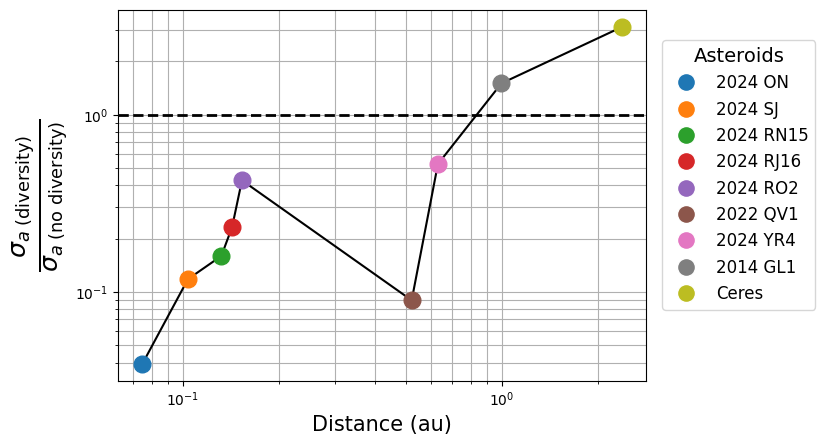

In [15]:
colors = plt.cm.tab10.colors
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid(True, which='both', axis='both')

ax1.set_xlabel('Distance (au)', fontsize=15)
ax1.set_ylabel(r'$\frac{\sigma_{a\ \mathrm{(diversity)}}}{\sigma_{a\ \mathrm{(no\ diversity)}}}$', fontsize=26)

ax1.plot(average_distance, uncertainty_ratio_a, '-', color='black', alpha=1)
for i in range(len(asteroids)):
    ax1.plot(average_distance[i], uncertainty_ratio_a[i], 'o', color=colors[i % len(colors)], markersize=12)
    
ax1.axhline(1, color='black', linestyle='--', linewidth=2)

asteroid_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=asteroids[i],
               markerfacecolor=colors[i % len(colors)], markersize=13)
    for i in range(len(asteroids))]
fig.legend(handles=asteroid_handles, title="Asteroids",
           loc='center left', bbox_to_anchor=(0.82, 0.55),
           fontsize=12, title_fontsize=14)

fig.tight_layout()
plt.subplots_adjust(left=0.15, right=0.81, top=0.88)
plt.savefig("uncertainty_ratio_plot.png", dpi=300, bbox_inches='tight')
plt.show()

##### Summary: 

##### In this notebook, we process Horizons-generated ephemerides for nine different asteroids to evaluate how diversity and non-diversity in observations affect orbital determination. For each object with the two cases, the raw Horizons text files are converted into MPC-formatted .obs files suitable for Find_Orb. In total, each asteroid has two files, totaling 18 files. 

##### Once the .obs files are generated, we process the file into Find_Orb, and the results are attached to the .pdf file on GitHub. From each orbit solution, we extract the formal uncertainty in the semi-major axis returned by Find_Orb, which quantifies how much the inclusion of diversity improves (or does not improve) the orbit solution. Finally, we plot this ratio as a function of each asteroid’s topocentric parallax distance. 

##### Overall, this workflow demonstrates that close-approaching NEOs show the greatest improvement in semi-major axis precision when diversity is included, while distant main-belt asteroids experience minimal gain. This validates the role of observational diversity in strengthening early orbit determination for near-Earth objects.